# 选择特征
在选择合适的特征时，可以考虑一些经验法则。例如，如果想要非常精确地分割对象，应该使用小的半径/sigma值。如果只需要大致轮廓，或者需要消除对象边界上的单个像素，使用较大的半径和sigma值是有意义的。然而，这个话题也可以通过统计学的方法来处理。

In [1]:
from skimage.io import imread, imsave
import pyclesperanto_prototype as cle
import numpy as np
import apoc
import matplotlib.pyplot as plt
import pandas as pd

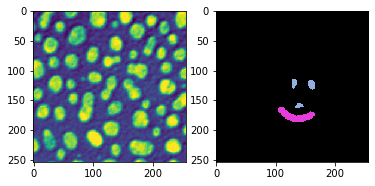

In [2]:
image = imread('../../data/blobs.tif')

manual_annotation = imread('../../data/blobs_annotations.tif')

fig, axs = plt.subplots(1,2)

cle.imshow(image, plot=axs[0])
cle.imshow(manual_annotation, labels=True, plot=axs[1])

## 训练 - 使用过多特征
现在我们训练一个对象分割器，并提供许多特征。我们还需要提供参数来配置深度决策树和多棵树。这是必要的，以便下一步，即推导统计数据，有足够的统计能力。
之后，我们快速查看结果以进行理智检查。

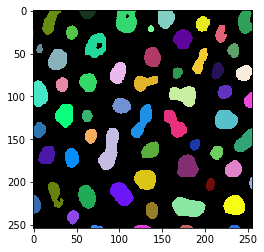

In [3]:
# define features
features = apoc.PredefinedFeatureSet.small_dog_log.value + " " + \
           apoc.PredefinedFeatureSet.medium_dog_log.value + " " + \
           apoc.PredefinedFeatureSet.large_dog_log.value

# this is where the model will be saved
cl_filename = '../../data/blobs_object_segmenter2.cl'

apoc.erase_classifier(cl_filename)
classifier = apoc.ObjectSegmenter(opencl_filename=cl_filename, 
                           positive_class_identifier=2, 
                           max_depth=5,
                           num_ensembles=1000)
classifier.train(features, manual_annotation, image)

segmentation_result = classifier.predict(features=features, image=image)
cle.imshow(segmentation_result, labels=True)

## 分类器统计
训练后，我们可以打印出分类器的一些统计信息。它给出了使用的特征表以及这些特征在像素分类决策中的重要性。

In [4]:
shares, counts = classifier.statistics()

def colorize(styler):
    styler.background_gradient(axis=None, cmap="rainbow")
    return styler

df = pd.DataFrame(shares).T
df.style.pipe(colorize)

在这个可视化中，你可以看到特征 `gaussian_blur=1`、`difference_of_gaussian=5` 和 `laplace_box_of_gaussian_blur=5` 占据了大约65%的决策。在第一级（级别 `0`）。如果这三个特征至关重要，我们可以训练另一个只考虑这些特征的分类器。此外，我们看到在更高的三个深度级别上，特征使用的份额分布更加均匀。这些级别在分类像素时可能不会产生很大的差异。下一个我们训练的分类器，我们可以用较低的 `max_depth` 来训练。

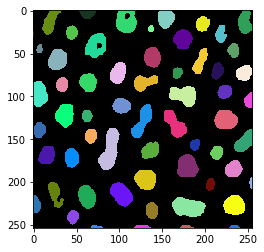

In [5]:
# define features
features = "gaussian_blur=1 difference_of_gaussian=5 laplace_box_of_gaussian_blur=5"

# this is where the model will be saved
cl_filename = '../../data/blobs_object_segmenter3.cl'

apoc.erase_classifier(cl_filename)
classifier = apoc.ObjectSegmenter(opencl_filename=cl_filename, 
                           positive_class_identifier=2, 
                           max_depth=3,
                           num_ensembles=1000)
classifier.train(features, manual_annotation, image)

segmentation_result = classifier.predict(features=features, image=image)
cle.imshow(segmentation_result, labels=True)

新的分类器仍然产生了非常相似的结果。它考虑的特征更少，这使得它更快，但可能也对图像和成像条件之间的差异不那么稳健。我们再看一下分类器统计：

In [6]:
shares, counts = classifier.statistics()
df = pd.DataFrame(shares).T
df.style.pipe(colorize)

为了演示目的，我们现在将训练另一个具有非常相似特征的分类器。

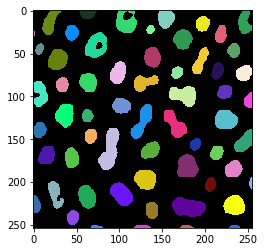

In [7]:
# define features
features = "gaussian_blur=1 difference_of_gaussian=2 difference_of_gaussian=3 difference_of_gaussian=4 difference_of_gaussian=5 difference_of_gaussian=6 laplace_box_of_gaussian_blur=5"

# this is where the model will be saved
cl_filename = '../../data/blobs_object_segmenter3.cl'

apoc.erase_classifier(cl_filename)
classifier = apoc.ObjectSegmenter(opencl_filename=cl_filename, 
                           positive_class_identifier=2, 
                           max_depth=3,
                           num_ensembles=1000)
classifier.train(features, manual_annotation, image)

segmentation_result = classifier.predict(features=features, image=image)
cle.imshow(segmentation_result, labels=True)

再次，分割结果看起来非常相似，但分类器统计不同。

In [8]:
shares, counts = classifier.statistics()
df = pd.DataFrame(shares).T
df.style.pipe(colorize)

通过这种方式，还可以微调指定特征需要使用的半径和sigma参数。

本节中给出的提示并不是选择正确特征的固定规则。不过，提供的工具可能有助于稍微深入了解特征，并衡量提供的特征列表和参数的影响。